# U-nets, vortex detection, and semantic segmentation

In this file, we will train a semantic image segmentation network to identify regions of high vorticity and velocity in our simulation, given only a screenshot of the fluid density. One appropriate choice of network architecture for this scenario is the U-net, named for its characteristic shape:

![](images/unet-arch.png)

Image courtesy of [[1]](https://arxiv.org/abs/1505.04597).

The intuition behind the U-net is that convolutional implementations coarse-grain data in the input image in order to extract low-level feature data. Coarse-graining is a non-invertible process and thus destroys information about correlations, so we feed the data at each layer forward, to build up an image which has the same size and resolution as the input and has access to the correlations learned at each CONV block.

In [27]:
import numpy as np
import tensorflow as tf
import graphviz as GraphViz
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, UpSampling2D, Cropping2D, Concatenate
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import pydot
from IPython.display import SVG
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
from data_utils import *

In [28]:
def ConvBlock(X, basename, filters=64, size=3, stride=1):
    """
    Implementation of a single convolutional block in the UNet

    Arguments:
    X  -- the network state
    basename -- how TensorFlow will refer to this ConvBlock
    filter -- how many channels to produce in the layer
    size -- filter size (square)
    stride -- convolution stride amount

    Returns:
    X after the convolution is achieved
    """
    
    X = Conv2D(filters, (size, size), strides = (stride, stride), name = basename+'a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_'+basename+'a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters, (size, size), strides = (stride, stride), name = basename+'b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_'+basename+'b')(X)
    X = Activation('relu')(X)
    
    return X

In [29]:
def UpConv(X, X_shortcut, sampling=2):
    """
    Implementation of the up-conv step depicted above.

    Arguments:
    X -- the network state
    X_shortcut -- the shortcut state to combine with X after upsampling
    sampling -- the factor by which to upsample (recommended 2)

    Returns: 
    X after the upscaling is achieved and the short-circuit implemented
    """
    
    X = UpSampling2D(size=(sampling, sampling), interpolation='nearest')(X)
    
    # Shortcut will be larger than the shape, so prepare to crop
    crop_x = X_shortcut.shape.as_list()[1] - X.shape.as_list()[1]
    crop_y = X_shortcut.shape.as_list()[2] - X.shape.as_list()[2]

    # In case the shape difference is odd for some reason, keep track
    x_rem = crop_x % 2
    y_rem = crop_y % 2
    
    # Get the correct numbers to crop by
    crop_x = int(np.floor(float(crop_x)/2.0))
    crop_y = int(np.floor(float(crop_y)/2.0))
    
    # Crop the shortcut and add in filters to ensure that it has the same as X. 
    X_shortcut = Cropping2D(cropping = ((crop_x,crop_x + x_rem),(crop_y,crop_y + y_rem)))(X_shortcut)
    X_shortcut = Concatenate(axis=-1)([X_shortcut,X_shortcut])
    
    # Add the layers
    X = Add()([X_shortcut,X])
    return X

In [30]:
def UNet(input_shape = (512, 512, 3), filters_init=64):
    """
    Implementation of UNet architecture depicted above.

    Arguments:
    input_shape -- shape of the images of the dataset
    filters_init -- number of filters in the first ConvBlock

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    X = ConvBlock(X_input, 'convd1', filters=filters_init, size=3, stride=1) # Stage 1, downward moving
    X_shortcut_1 = X                                                         # Save shortcut
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)                              # Downward step 1 -> 2
    
    X = ConvBlock(X, 'convd2', filters=filters_init*2, size=3, stride=1)     # Stage 2, downward moving
    X_shortcut_2 = X                                                         # Save shortcut
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)                              # Downward step 2 -> 3
    
    X = ConvBlock(X, 'convd3', filters=filters_init*4, size=3, stride=1)     # Stage 3, downward moving
    X_shortcut_3 = X                                                         # Save shortcut
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)                              # Downward step 3 -> 4
    
    X = ConvBlock(X, 'convd4', filters=filters_init*8, size=3, stride=1)     # Stage 4, downward moving
    X_shortcut_4 = X                                                         # Save shortcut
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)                              # Downward step 4 -> 5
    
    X = ConvBlock(X, 'convd5', filters=filters_init*16, size=3, stride=1)    # Stage 5, bottom
    X = UpConv(X, X_shortcut_4, sampling=2)                                  # Upward step 5 -> 4, adding short circuit
    
    X = ConvBlock(X, 'convu4', filters=filters_init*8, size=3, stride=1)     # Stage 4, upward moving
    X = UpConv(X, X_shortcut_3, sampling=2)                                  # Upward step 4 -> 3, adding short circuit
    
    X = ConvBlock(X, 'convu3', filters=filters_init*4, size=3, stride=1)     # Stage 3, upward moving
    X = UpConv(X, X_shortcut_2, sampling=2)                                  # Upward step 3 -> 2, adding short circuit
    
    X = ConvBlock(X, 'convu2', filters=filters_init*2, size=3, stride=1)     # Stage 2, upward moving
    X = UpConv(X, X_shortcut_1, sampling=2)                                  # Upward step 2 -> 1, adding short circuit
    
    X = ConvBlock(X, 'convu1', filters=filters_init, size=3, stride=1)       # Stage 1, top
    
    # Output layer
    X = Conv2D(1, (1, 1), strides = (1, 1), name = 'convOut', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_convOut')(X)
    X = Activation('sigmoid')(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='UNet')

    return model

In [31]:
# Define the model
model = UNet(input_shape = (572, 572, 3), filters_init = 64)

In [32]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [95]:
# Load the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
#Y_train = convert_to_one_hot(Y_train_orig, 6).T
#Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

NameError: name 'load_dataset' is not defined

In [ ]:
model.fit(X_train, Y_train, epochs = 2, batch_size = 32)

In [ ]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

In [ ]:
img_path = 'images/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
print('Input image shape:', x.shape)
my_image = scipy.misc.imread(img_path)
imshow(my_image)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(model.predict(x))

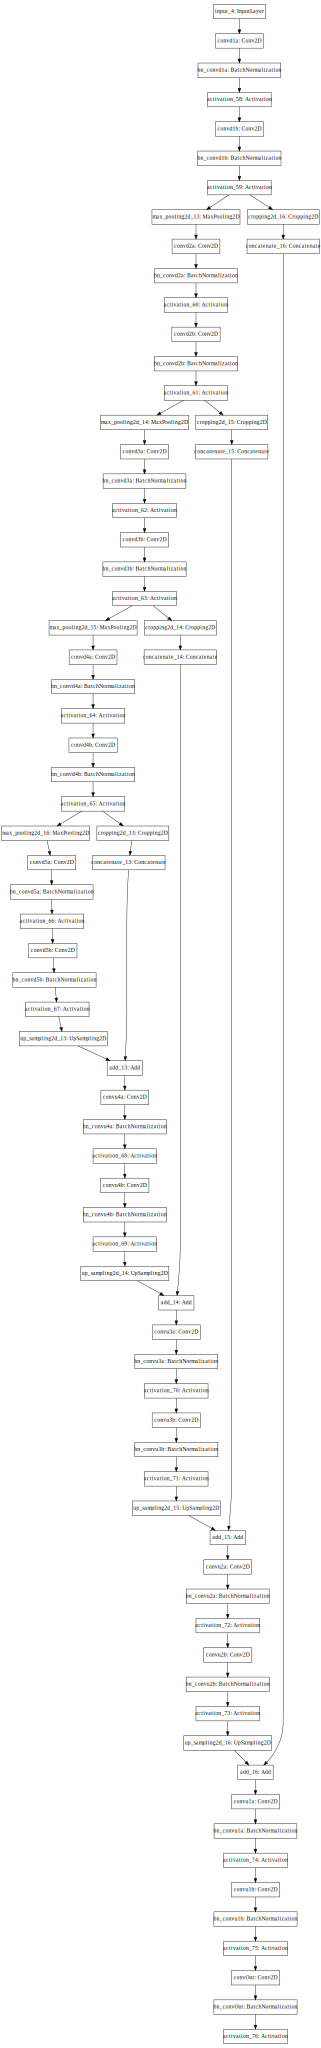

In [39]:
plot_model(model)
SVG(model_to_dot(model).create(prog='dot', format='svg'))